This notebook is based on ideas from: [The Causal Inference "do" Operator Fully Explained with an End-to-End Example using Python and DoWhy](https://github.com/grahamharrison68/Public-Github/blob/master/Causal%20Inference/Do%20Operator%20v2.ipynb).

In [35]:
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

In [36]:
import pandas as pd
import numpy as np
print()
df_lalonde=pd.read_csv("data/lalonde.csv").iloc[:, [1, 2, 3, 4, 5, 6, 7, 10]]
df_lalonde.rename(columns={"hispan": "hisp", "nodegree": "nodegr"}, inplace=True)

features : list = list(df_lalonde.columns)

# This is just to demonstrate that the dowhy do operator can cope with categorical data types
df_lalonde["black"] = np.where(df_lalonde["black"] == 1, "yes", "no") 
    
top_earner_percentile : int = 75
top_earner_boundary : float = np.percentile(df_lalonde["re78"], top_earner_percentile)

df_lalonde["topearner"] = np.where(df_lalonde["re78"] > top_earner_boundary, 1, 0)
df_lalonde["age group"] = pd.cut(df_lalonde["age"], bins=[0, 25, 30, 40, 50, 60])

df_lalonde

,treat,age,educ,black,hisp,married,nodegr,re78,topearner,age group
0,1,37,11,yes,0,1,1,9930.0460,0,"(30, 40]"
1,1,22,9,no,1,0,1,3595.8940,0,"(0, 25]"
2,1,30,12,yes,0,0,0,24909.4500,1,"(25, 30]"
3,1,27,11,yes,0,0,1,7506.1460,0,"(25, 30]"
4,1,33,8,yes,0,0,1,289.7899,0,"(30, 40]"
...,...,...,...,...,...,...,...,...,...,...
609,0,18,11,no,0,0,1,10150.5000,0,"(0, 25]"
610,0,24,1,no,1,1,1,19464.6100,1,"(0, 25]"
611,0,21,18,no,0,0,0,0.0000,0,"(0, 25]"
612,0,32,5,yes,0,1,1,187.6713,0,"(30, 40]"


Dataset:

- The "treat" column contains a 1 of the individual participated in the training and a 0 if they did not.
- "re78" is the relative earnings of the individual in 1978 which was at the end of the observation period.
- "educ" represents the years of education that the individual has had.
- The other features represent yes / no attributes of the individual e.g. "nodegr" = 1 represents the individual not having a college degree.
- I have feature engineered "topearner" to hold a 1 if the earnings are in the top quartile and "age group" to categorise the participant age into bins.

A full explanation the dataset features can be found here - https://rdrr.io/cran/designmatch/man/lalonde.html.

## What impact did the training programme seem to have?
Now let's take a look at the data to see what impact the training programme had on the participants' earnings ..

In [37]:
treat_filter = df_lalonde["treat"] == 1

impact_of_training = df_lalonde[treat_filter]["re78"].mean() - df_lalonde[~treat_filter]["re78"].mean()

top_earner_treatment = df_lalonde[treat_filter]["topearner"].value_counts(normalize=True)
top_earner_no_treatment = df_lalonde[~treat_filter]["topearner"].value_counts(normalize=True)
#print(df_lalonde[treat_filter]["topearner"].value_counts(normalize=True))
p_top_earner_treatment = top_earner_treatment[1]
p_top_earner_no_treatment = top_earner_no_treatment[1]

print(f"The average impact of participation in the job training program on earnings is ${impact_of_training:+0,.2f}\n")
print(f"P(top earner=1 | treatment=1) = {p_top_earner_treatment}")
print(f"P(top earner=1 | treatment=0) = {p_top_earner_no_treatment}")

df_lalonde.groupby("treat")["re78"].agg(["median","mean"])

The average impact of participation in the job training program on earnings is $-635.03

P(top earner=1 | treatment=1) = 0.1945945945945946
P(top earner=1 | treatment=0) = 0.27505827505827507


,median,mean
treat,,
0,4975.505,6984.169742
1,4232.309,6349.143530


Interpretation:

- The apparent impact of attending the training programme is a decrease in annual earnings of \\$635. 
- The probability of being a top earner is 0.19 for those attending the training and 0.28 for those not attending.
- The median earnings for those who received the training is \\$4,232 and \\$4,976 for those who were not trained.
- The mean earnings for those who received the training is \\$6,349 and \\$6,984 for those who were not trained.

## What Advice Would You Give?
Based on the analysis the clear advice would be to stop the training programme as it can be shown using four different measures that the impact on earnings is consistently negative.

Intuitively this conclusion does not seem right though. Even if the training was absolutely terrible it does not feel right that attending the training would make a participant less employable and damage their future earnings.

## What Went Wrong with the Analysis?
At this point the potential for traditional approaches including probabilities and predictive models cannot get us any further. Any application of these techniques will conclude that the training should be cancelled.

In order to break through those limitations and to really understand what is going on we need to use causal inference techniques to build a causal model and to apply the "do" operator.

If you want to know the true impact of the training programme and why using traditional probabilities and predictive models can cause erroneous and even dangerous outcomes, please read on ...

## A Causal Inference Solution Using The "do" Operator
Let's take a more detailed look at some of the features in the dataset.

In [38]:
import matplotlib.pyplot as plt

def plot_comparison(feature : str, normalize : bool = True):
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

    df_lalonde[~treat_filter][feature].value_counts(normalize=normalize).sort_index().plot(ax=axes[0], kind="bar", title="No Training", xlabel=feature, ylim=(0,1) if normalize else False)
    df_lalonde[treat_filter][feature].value_counts(normalize=normalize).sort_index().plot(ax=axes[1], kind="bar", title="Received Training", xlabel=feature, ylim=(0,1) if normalize else False)

    plt.show()

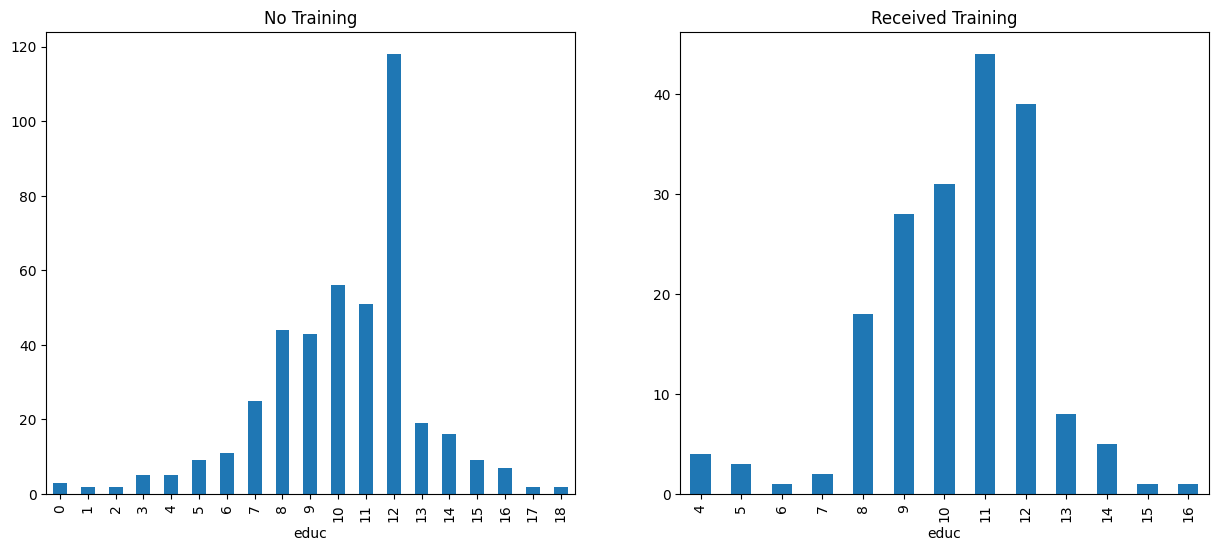

In [35]:
plot_comparison("educ", normalize=False)

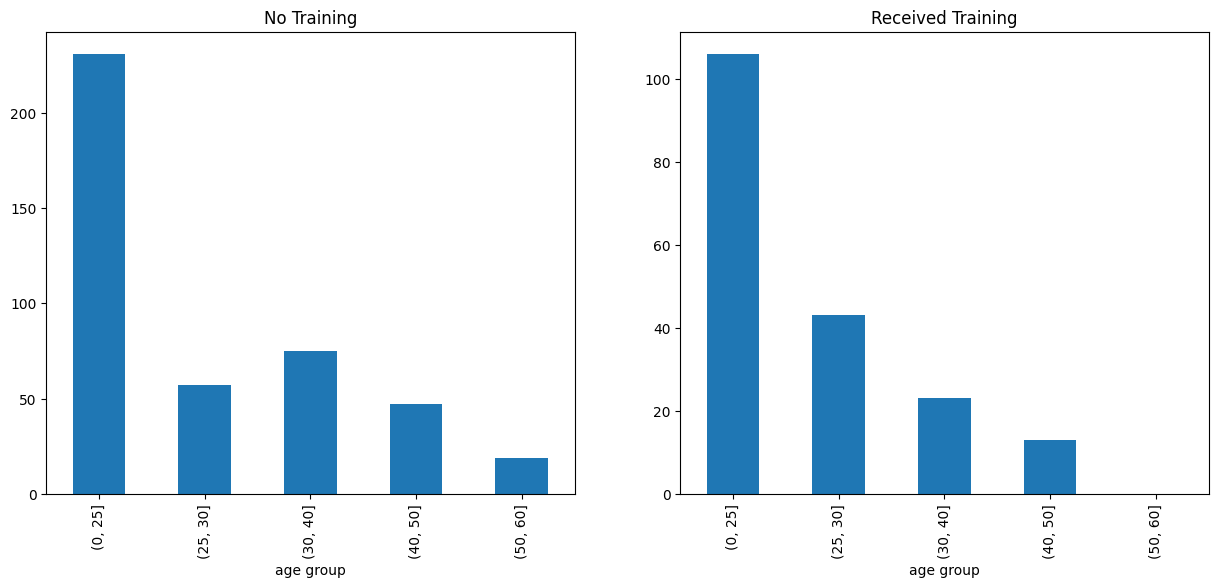

In [39]:
plot_comparison("age group", normalize=False)

It is a similar story for age. For those receiving training it is a linear pattern with more younger people and less older people. For no training there is a spike in the 30-40 age group. One hypothesis might be that many 30-40 year olds are already earning well and do not want any job-skills related training.

Again this would suggest that age is affecting both whether an individual is likely to attend the training and their earnings potential.

## Building a "Directed Acyclic Graph" (DAG)
It is not possible to discover causality in data on its own. 
The data needs to be supplemented with a "Directed Acyclic Graph" (DAG) that is constructed by "discovering" the causal relationships by utilizing domain expertise and other techniques for causal discovery.

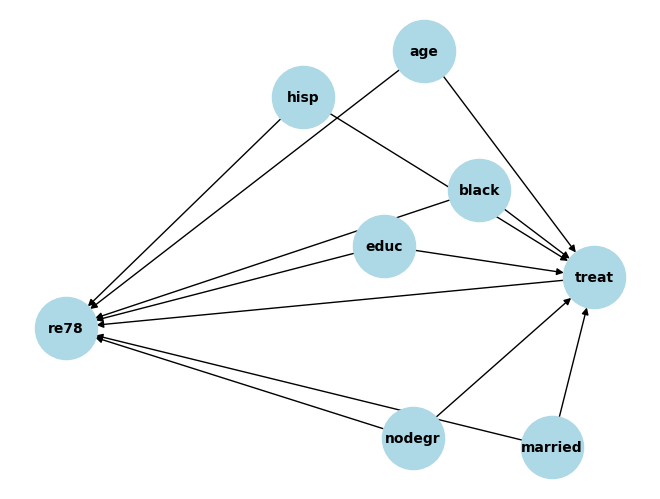

In [16]:
import networkx as nx
import matplotlib.pyplot as plt
causal_graph = nx.DiGraph([("age", "treat"), ("age", "re78"),
                               ("educ", "treat"), ("educ", "re78"),
                               ("black", "treat"), ("black", "re78"),
                               ("hisp", "treat"), ("hisp", "re78"),
                               ("married", "treat"), ("married", "re78"),
                               ("nodegr", "treat"), ("nodegr", "re78"),
                               ("treat", "re78")])

# Visualize the graph
nx.draw(causal_graph, with_labels=True, node_size=2000, node_color='lightblue', font_size=10, font_weight='bold')
plt.show()

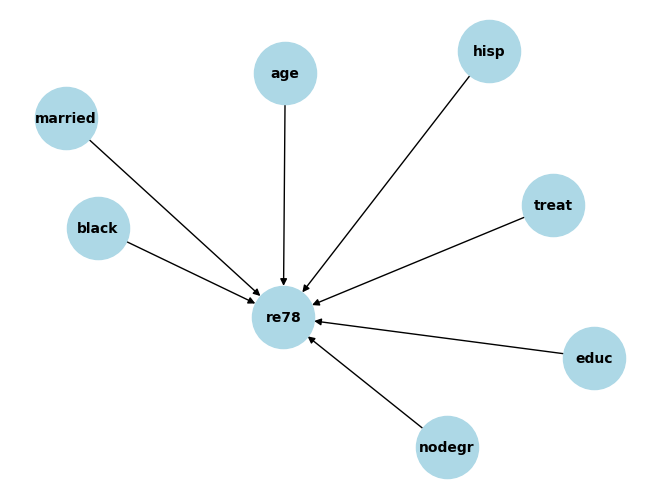

In [17]:
do_model_edges : list = [("age", "re78"),
                         ("educ", "re78"),
                         ("black", "re78"),
                         ("hisp", "re78"),
                         ("married", "re78"),
                         ("nodegr", "re78"),
                         ("treat", "re78")]
causal_graph_intervened = nx.DiGraph(do_model_edges)

# Visualize the graph
nx.draw(causal_graph_intervened, with_labels=True, node_size=2000, node_color='lightblue', font_size=10, font_weight='bold')
plt.show()

In [26]:
import numpy as np
import dowhy.api

np.random.seed(42) 

variable_types : dict = {"treat": "d", "age": "c", "educ": "c", "black": "d", "hisp": "d", "married": "d", "nodegr": "d", "re78": "c", "topearner": "d", "age group": "d"}
    
df_do_lalonde = df_lalonde.causal.do(x={"treat": 1},
                                     outcome="re78",
                                     graph=causal_graph, 
                                     variable_types=variable_types)

display(df_do_lalonde.groupby("treat")["re78"].agg(["median","mean"]))

INFO:dowhy.causal_identifier.auto_identifier:Causal effect can be identified.
INFO:dowhy.causal_identifier.auto_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier.auto_identifier:Frontdoor variables for treatment and outcome:[]
INFO:dowhy.do_sampler:Using WeightingSampler for do sampling.
INFO:dowhy.do_sampler:Caution: do samplers assume iid data.


,median,mean
treat,,
1,5149.501,7131.186645


## What Does the Code Mean?
Before we get into the truly amazing results it would be useful to walk through the code line-by-line.

Firstly, importing ``dowhy.api`` magically extends pandas dataframes so that the gain a new ``causal.do`` method. 

Next setting the random seed in numpy ensures that the ``do`` method is reproducable and the same results will be produced on every run. The ``DoWhy`` documentation does not mention anything about setting a random seed and this was found by pure trial-and-error. Also to note, the random seed needs to be set in the preceeding statement before every call to ``causal.do``, not just before the first one.

The next mystery of ``causal.do`` is the ``variable_types`` parameter. The ``DoWhy`` documentation is incomplete and inconsistent. Trying out lots of different things has led to the following conclusions -

- Despite what the documentation says there are only 2 types that are important are "d" for discrete and "c" for continuous.
- In statistics an integer is discrete but ``DoWhy`` produces some very odd results if integers are declared as "d". Based on pouring over the ``DoWhy`` documentation examples my conclusion is that integers need to be declared as type "c" for continuous.
- Inside the ``DoWhy`` source code there is a method called ``infer_variable_types`` but it is stubbed out with no implementation so I have written my own implementation which is available as a static method in ``DirectedAcyclicGraph.infer_variable_types()``.

Here is what the all-important ``causal.do`` method parameters mean -

- ``x={"treat": 1}`` is saying what it is we want to "do". In this case we want to see what happens if everyone were forced to take the training which is represented in the data by ``treat=1``.
- ``outcome="re78"`` - this is the outcome or effect we are looking for. What is the effect of "doing" treat=1 on the individuals salary (the relative earnings in 1978).
- ``dot_graph=lalonde_model.gml_graph`` is informing the ``do`` operator of the causal relationships we believe exist in the data. ``lalonde_model`` is an instance of my ``DirectedAcyclicGraph`` class and I have given it a property which spits out the structure in gml format -
    - The ``do`` method requires either ``common_causes`` or ``dot_graph`` to be passed in to describe the causal relationships.
    - The ``dot_graph`` parameter will accept a structure in either ``dot`` or ``gml`` format but this is not mentioned anywhere in the documentation; gml is much better in my opinion as it is used everywhere else in ``DoWhy``.
    - Specifying a graph is much better than setting ``common_causes`` as a graph can capture any type of structure whereas ``common_causes`` is much more limiting. Again this is not mentioned anywhere in the ``DoWhy`` documentation.
- The ``variable_types`` parameter has already been explained.

## How Does it Work?
The ``causal.do`` method is returning a new dataframe that effectively simulates a forced intervention and provides the data that would have been collected had everyone done the training -

In [27]:
df_do_lalonde["treat"].value_counts()

treat
1    614
Name: count, dtype: int64

``DoWhy`` is different to most of the other Python causal libraries in this respect as most of the other libraries just to return  a number and not a dataset. 

Returning a ``DataFrame`` is initially a bit confusing but dig a little deeper and it is a powerful, flexible and informative approach.

The do operator resamples the data, e.g. via the propensity scores to obtain well balanced data, by performing a quasi randomized controlled trial. 

Take a look at a comparison of the following feature across the original observed data and the new intervention data -

In [30]:
def plot_do_comparison(feature : str, normalize : bool = True):
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

    df_lalonde[treat_filter][feature].value_counts(normalize=normalize).sort_index().plot(ax=axes[0], kind="bar", title="Received Training - Observation", xlabel=feature, ylim=(0,1) if normalize else False)
    df_do_lalonde[feature].value_counts(normalize=normalize).sort_index().plot(ax=axes[1], kind="bar", title="Received Training - Intervention", xlabel=feature, ylim=(0,1) if normalize else False)

    plt.show()

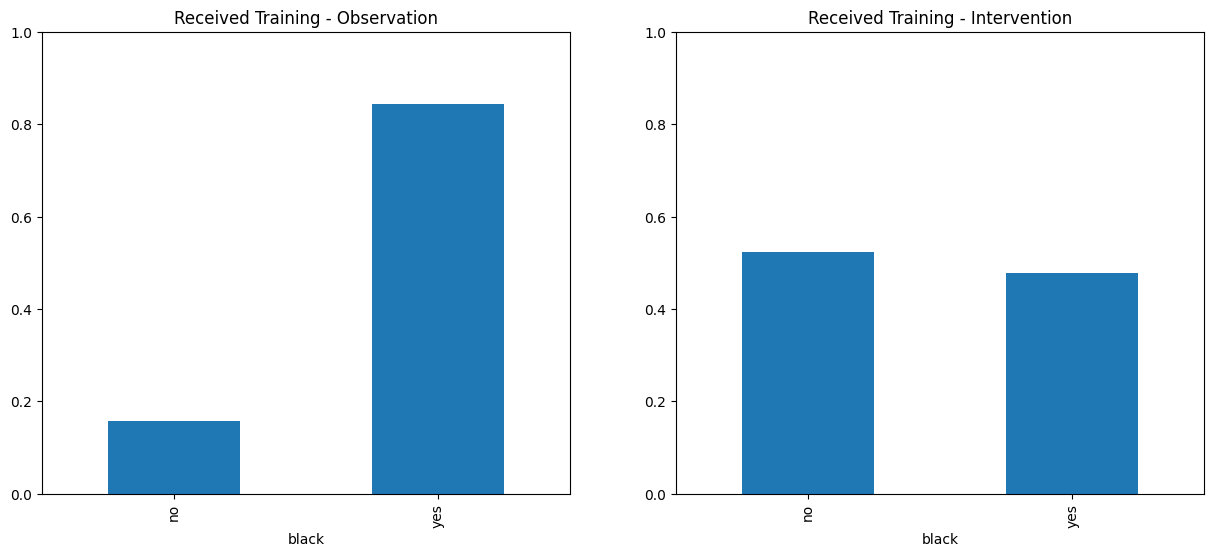

In [31]:
plot_do_comparison("black", normalize=True)

## What is the True, "Deconfounded" Impact of the Training on Earnings?
Now all that remains is to interpret the true impact of the training on earnings by taking a look inside the ``do`` dataframe

In [32]:
print("Median and mean earnings of those receiving training from the interventional data")
display(df_do_lalonde.groupby("treat")["re78"].agg(["median","mean"]))

print("Median and mean earnings of those receiving training from the original observational data")
display(df_lalonde[treat_filter].groupby("treat")["re78"].agg(["median","mean"]))

Median and mean earnings of those receiving training from the interventional data


,median,mean
treat,,
1,5149.501,7131.186645


Median and mean earnings of those receiving training from the original observational data


,median,mean
treat,,
1,4232.309,6349.14353


## References

LaLonde dataset:
- Citation: LaLonde, Robert J, 1986. "Evaluating the Econometric Evaluations of Training Programs with Experimental Data," American Economic Review, American Economic Association, vol. 76(4), pages 604-620, September.
- Source (including license details): https://users.nber.org/~rdehejia/nswdata2.html
- Explanation: https://rdrr.io/cran/designmatch/man/lalonde.html